**Use GPU: Runtime -> Change runtime type -> GPU (Hardware Accelerator)**

In [ ]:
!cat ~/.keras/keras.json 

{
    "epsilon": 1e-07, 
    "floatx": "float32", 
    "image_data_format": "channels_last", 
    "backend": "tensorflow"
}

Preprocessing

In [ ]:
import numpy as np
import imutils
import cv2
import os
from keras.preprocessing.image import img_to_array

class AspectAwarePreprocessor:
  def __init__(self, width, height, inter=cv2.INTER_AREA):
    # store the target image width, height, and interpolation
    # method used when resizing
    self.width = width
    self.height = height
    self.inter = inter

  def preprocess(self, image):
    # grab the dimensions of the image and then initialize
    # the deltas to use when cropping
    (h, w) = image.shape[:2]
    dW = 0
    dH = 0

    # if the width is smaller than the height, then resize
    # along the width (i.e., the smaller dimension) and then
    # update the deltas to crop the height to the desired
    # dimension
    if w < h:
      image = imutils.resize(image, width=self.width,
        inter=self.inter)
      dH = int((image.shape[0] - self.height) / 2.0)

    # otherwise, the height is smaller than the width so
    # resize along the height and then update the deltas
    # crop along the width
    else:
      image = imutils.resize(image, height=self.height,
        inter=self.inter)
      dW = int((image.shape[1] - self.width) / 2.0)

    # now that our images have been resized, we need to
    # re-grab the width and height, followed by performing
    # the crop
    (h, w) = image.shape[:2]
    image = image[dH:h - dH, dW:w - dW]

    # finally, resize the image to the provided spatial
    # dimensions to ensure our output image is always a fixed
    # size
    return cv2.resize(image, (self.width, self.height),
      interpolation=self.inter)

class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		# store the image data format
		self.dataFormat = dataFormat

	def preprocess(self, image):
		# apply the Keras utility function that correctly rearranges
		# the dimensions of the image
		return img_to_array(image, data_format=self.dataFormat)
  
class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors

        # if the preprocessors are None, initialize them as an empty list
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []

        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load the image and extract the class label assuming
            # that our path has the following format:
            # /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]

            # check to see if our preprocessors are not None
            if self.preprocessors is not None:
                # loop over the preprocessors and apply each to
                # the image
                for p in self.preprocessors:
                    image = p.preprocess(image)

            # treat our processed image as a "feature vector"
            # by updating the data list followed by the labels
            data.append(image)
            labels.append(label)

            # show an update every `verbose` images
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1,
                    len(imagePaths)))

        # return a tuple of the data and labels
        return (np.array(data), np.array(labels))

Mini-VGGNet

In [ ]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

In [ ]:
class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

Train Mini-VGGNet (Flowers 17) w/ Data Augmentation

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
def train_minivggnet_flowers17(dataset_filepath, data_augment):
    # grab the list of images that we'll be describing, then extract
    # the class label names from the image paths
    print("[INFO] loading images...")
    imagePaths = list(paths.list_images(dataset_filepath))
    classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
    classNames = [str(x) for x in np.unique(classNames)]

    # initialize the image preprocessors
    aap = AspectAwarePreprocessor(64, 64)
    iap = ImageToArrayPreprocessor()

    # load the dataset from disk then scale the raw pixel intensities
    # to the range [0, 1]
    sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
    (data, labels) = sdl.load(imagePaths, verbose=500)
    data = data.astype("float") / 255.0

    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

    # convert the labels from integers to vectors
    trainY = LabelBinarizer().fit_transform(trainY)
    testY = LabelBinarizer().fit_transform(testY)

    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.05)
    model = MiniVGGNet.build(width=64, height=64, depth=3, classes=len(classNames))
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    if data_augment:
        # construct the image generator for data augmentation
        aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
            height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
            horizontal_flip=True, fill_mode="nearest")
        # train the network
        print("[INFO] training network...")
        H = model.fit_generator(aug.flow(trainX, trainY, batch_size=32),
            validation_data=(testX, testY), steps_per_epoch=len(trainX) // 32,
            epochs=100, verbose=1)
    else:
        # train the network
        print("[INFO] training network...")
        H = model.fit(trainX, trainY, validation_data=(testX, testY),
            batch_size=32, epochs=100, verbose=1)

    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=classNames))
    
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

[INFO] loading images...
[INFO] processed 500/1360
[INFO] processed 1000/1360
[INFO] compiling model...
[INFO] training network...
Epoch 1/100
32/32 [==============================] - 29s 876ms/step - loss: 3.6532 - accuracy: 0.1665 - val_loss: 3.8614 - val_accuracy: 0.1382
Epoch 2/100
32/32 [==============================] - 27s 860ms/step - loss: 1.8320 - accuracy: 0.4953 - val_loss: 3.0366 - val_accuracy: 0.1735
Epoch 3/100
32/32 [==============================] - 27s 858ms/step - loss: 1.4406 - accuracy: 0.5765 - val_loss: 4.3354 - val_accuracy: 0.1147
Epoch 4/100
32/32 [==============================] - 27s 857ms/step - loss: 1.1941 - accuracy: 0.6552 - val_loss: 3.1437 - val_accuracy: 0.1882
Epoch 5/100
32/32 [==============================] - 27s 852ms/step - loss: 0.7102 - accuracy: 0.7686 - val_loss: 2.8504 - val_accuracy: 0.2676
Epoch 6/100
32/32 [==============================] - 27s 855ms/step - loss: 0.5095 - accuracy: 0.8279 - val_loss: 2.8690 - val_accuracy: 0.2882
Epoch

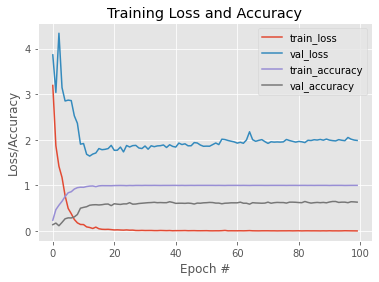

In [ ]:
train_minivggnet_flowers17(dataset_filepath="drive/MyDrive/pyimagesearch/datasets/flowers17", data_augment=False)

[INFO] loading images...
[INFO] processed 500/1360
[INFO] processed 1000/1360
[INFO] compiling model...
[INFO] training network...
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


31/31 [==============================] - 35s 71ms/step - loss: 3.6822 - accuracy: 0.1640 - val_loss: 3.4067 - val_accuracy: 0.1794
Epoch 2/100
31/31 [==============================] - 1s 45ms/step - loss: 2.3708 - accuracy: 0.3758 - val_loss: 2.7883 - val_accuracy: 0.1824
Epoch 3/100
31/31 [==============================] - 1s 47ms/step - loss: 2.0009 - accuracy: 0.4197 - val_loss: 2.4798 - val_accuracy: 0.2794
Epoch 4/100
31/31 [==============================] - 1s 47ms/step - loss: 1.7417 - accuracy: 0.4802 - val_loss: 2.2412 - val_accuracy: 0.2676
Epoch 5/100
31/31 [==============================] - 2s 49ms/step - loss: 1.7130 - accuracy: 0.5075 - val_loss: 1.9655 - val_accuracy: 0.3471
Epoch 6/100
31/31 [==============================] - 1s 47ms/step - loss: 1.6143 - accuracy: 0.5072 - val_loss: 2.4822 - val_accuracy: 0.2971
Epoch 7/100
31/31 [==============================] - 2s 49ms/step - loss: 1.3679 - accuracy: 0.5601 - val_loss: 1.7767 - val_accuracy: 0.3912
Epoch 8/100
31/31

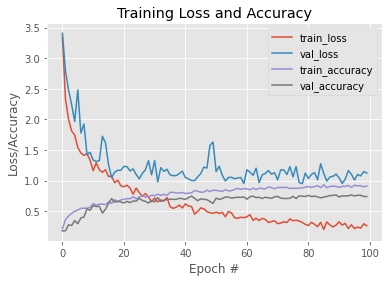

In [ ]:
train_minivggnet_flowers17(dataset_filepath="drive/MyDrive/pyimagesearch/datasets/flowers17", data_augment=True)